In [2]:
# !pip install line_profiler
# %load_ext line_profiler

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Union, Type


In [5]:
df = pl.read_parquet("kills_df_model_ready_v2.parquet")
df.head()

blue_champion,blue_level,blue_items,blue_gold,blue_role,blue_general_runes,blue_summoners,winner,red_champion,red_level,red_items,red_gold,red_role,red_general_runes,red_summoners
str,i64,list[str],i64,str,str,list[str],str,str,i64,list[str],i64,str,str,list[str]
"""Ezreal""",6,"[""1036"", ""3340"", ... ""3057""]",1800,"""BOTTOM""","""8005,8009,9103...","[""Flash"", ""Heal""]","""blue""","""Twitch""",6,"[""1055"", ""3006"", ... ""2031""]",2350,"""BOTTOM""","""8008,8009,9104...","[""Flash"", ""Ghost""]"
"""Twitch""",6,"[""1055"", ""3006"", ... ""2031""]",2350,"""BOTTOM""","""8008,8009,9104...","[""Flash"", ""Ghost""]","""red""","""Ezreal""",6,"[""1036"", ""3340"", ... ""3057""]",1800,"""BOTTOM""","""8005,8009,9103...","[""Flash"", ""Heal""]"
"""KSante""",8,"[""1054"", ""3340"", ... ""1033""]",2950,"""TOP""","""8437,8446,8429...","[""Flash"", ""Teleport""]","""red""","""Zac""",8,"[""1054"", ""3340"", ... ""1029""]",3200,"""TOP""","""8010,9111,9105...","[""Ignite"", ""Flash""]"
"""Zac""",8,"[""1054"", ""3340"", ... ""1029""]",3200,"""TOP""","""8010,9111,9105...","[""Ignite"", ""Flash""]","""blue""","""KSante""",8,"[""1054"", ""3340"", ... ""1033""]",2950,"""TOP""","""8437,8446,8429...","[""Flash"", ""Teleport""]"
"""Viego""",8,"[""1054"", ""3340"", ... ""1036""]",2600,"""MIDDLE""","""8010,9111,9104...","[""Ignite"", ""Ghost""]","""red""","""Katarina""",9,"[""1055"", ""1026"", ... ""3364""]",3985,"""MIDDLE""","""8010,9111,9105...","[""Flash"", ""Ignite""]"


In [6]:
# new more gold column

df = df.with_column(
  pl.when(pl.col("blue_gold") > pl.col("red_gold"))
  .then("blue")
  .otherwise("red")
  .alias("blue_more_gold")
)

/tmp/ipykernel_158922/3054300560.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "more", "less"])


Text(0, 0.5, 'percentage wins')

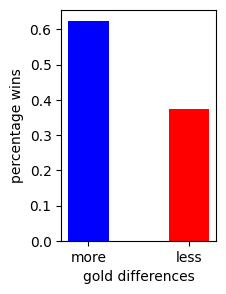

In [7]:
# Plot higher gold vs winner

more_gold_wins = df.filter(pl.col("winner") == pl.col("blue_more_gold")).shape[0] / df.shape[0]
less_gold_wins = df.filter(pl.col("winner") != pl.col("blue_more_gold")).shape[0] / df.shape[0]

_, ax = plt.subplots(figsize=(2, 3))
ax.bar([1, 1.5], [more_gold_wins, less_gold_wins], width=.2, color=["blue", "red"])
ax.set_xticklabels(["", "more", "less"])
ax.set_xlabel("gold differences")
ax.set_ylabel("percentage wins")

In [8]:
# Don't judge me
import sys
sys.path.append('../backend/app/')
from models.play_transformer import PlayTransformer

In [9]:
new_df = df.select(pl.exclude(pl.List(pl.Utf8)))

In [10]:
new_df.head()

blue_champion,blue_level,blue_gold,blue_role,blue_general_runes,winner,red_champion,red_level,red_gold,red_role,red_general_runes,blue_more_gold
str,i64,i64,str,str,str,str,i64,i64,str,str,str
"""Ezreal""",6,1800,"""BOTTOM""","""8005,8009,9103...","""blue""","""Twitch""",6,2350,"""BOTTOM""","""8008,8009,9104...","""red"""
"""Twitch""",6,2350,"""BOTTOM""","""8008,8009,9104...","""red""","""Ezreal""",6,1800,"""BOTTOM""","""8005,8009,9103...","""blue"""
"""KSante""",8,2950,"""TOP""","""8437,8446,8429...","""red""","""Zac""",8,3200,"""TOP""","""8010,9111,9105...","""red"""
"""Zac""",8,3200,"""TOP""","""8010,9111,9105...","""blue""","""KSante""",8,2950,"""TOP""","""8437,8446,8429...","""blue"""
"""Viego""",8,2600,"""MIDDLE""","""8010,9111,9104...","""red""","""Katarina""",9,3985,"""MIDDLE""","""8010,9111,9105...","""red"""


In [11]:
# df['red_keystone'] = df['red_general_runes'].apply(lambda p: p[0])

# Below func is pretty RAM heavy and slow

In [12]:
# # for debugging (first 100 columns)
# 
# n_cols = 20000
# 
# new_df = pl.get_dummies(df.lazy().fetch(n_cols), columns=["blue_champion", "red_champion"])
# 
# for l in list_cols:
#   new_df= new_df.hstack(
#   df
#   .lazy()
#   .select(
#     pl.col(l)
#     )
#   .with_row_count()
#   .explode(l)
#   .with_columns(pl.lit(1).alias('__one__'))
#   .fetch(n_cols)
#   .pivot(index='row_nr', columns=l, values='__one__')
#   .select(pl.exclude('row_nr').prefix(f"{l}_"))
#   .fill_null(0)
#   )

In [13]:
# # Testing limited features
# new_df = new_df.select(
#     ['^.*_champion_.*$', 'winner', 
#      '^[^_]*_gold$', '^*_level$']
# )

In [14]:
play_transformer = PlayTransformer()
whole_numeric_df = play_transformer.fit_transform(df)

In [15]:
whole_numeric_df.head()

blue_champion_Aatrox,blue_champion_Ahri,blue_champion_Akali,blue_champion_Akshan,blue_champion_Alistar,blue_champion_Amumu,blue_champion_Anivia,blue_champion_Annie,blue_champion_Aphelios,blue_champion_Ashe,blue_champion_AurelionSol,blue_champion_Azir,blue_champion_Bard,blue_champion_Belveth,blue_champion_Blitzcrank,blue_champion_Brand,blue_champion_Braum,blue_champion_Caitlyn,blue_champion_Camille,blue_champion_Cassiopeia,blue_champion_Chogath,blue_champion_Corki,blue_champion_Darius,blue_champion_Diana,blue_champion_DrMundo,blue_champion_Draven,blue_champion_Ekko,blue_champion_Elise,blue_champion_Evelynn,blue_champion_Ezreal,blue_champion_Fiddlesticks,blue_champion_Fiora,blue_champion_Fizz,blue_champion_Galio,blue_champion_Gangplank,blue_champion_Garen,blue_champion_Gnar,...,red_items_3139,red_items_7013,red_items_7027,red_items_6035,red_items_7011,red_items_6664,red_items_7005,red_items_7008,red_items_7028,red_items_2422,red_items_7006,red_items_3600,red_items_7001,red_items_7009,red_items_3119,red_items_7017,red_items_4638,red_items_7018,red_items_7012,red_items_7014,red_items_7016,red_items_7023,red_items_2421,red_items_7019,red_items_3599,red_items_7024,red_items_7022,red_items_7021,red_summoners_Flash,red_summoners_Ghost,red_summoners_Heal,red_summoners_Ignite,red_summoners_Teleport,red_summoners_Smite,red_summoners_Exhaust,red_summoners_Cleanse,red_summoners_Barrier
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [16]:
numeric_df = whole_numeric_df.sample(50000)

## Creating pytorch dataset

In [17]:
import re
WINNER_REGEX = '^winner_.+$'
winner_columns = numeric_df.select(pl.col(WINNER_REGEX)).columns
target2class_name = {k:winner_columns[k].replace('winner_', '') for k in range(len(winner_columns))}
target2class_name

{0: 'blue', 1: 'red'}

In [18]:
import torch
from tqdm import tqdm
from torch.utils.data.dataset import Dataset, random_split, Subset
from torch.utils.data import DataLoader

from einops import rearrange

from typing import Generator, Tuple

import helper_funcs

In [19]:
def seperate_data(d: pl.DataFrame) -> Tuple[pl.DataFrame, pl.DataFrame]:
  return d.select(pl.exclude(WINNER_REGEX)), d.select(pl.col(WINNER_REGEX))

In [20]:
train_data, test_data = helper_funcs.split_polars(numeric_df, split=0.2)

In [21]:
class LolData(Dataset):
  def __init__(self, data: pl.DataFrame) -> None:
    super().__init__()
    self.data, self.label = seperate_data(data)

  def __len__(self) -> int:
    return len(self.data)
  
  def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
    row = self.data[idx].to_numpy()
    row_label = self.label[idx].to_numpy()
    return torch.tensor(row, dtype=torch.float32).squeeze(), torch.tensor(row_label, dtype=torch.float32)

In [22]:
def make_loader(*ds: Subset, batch_size: int=32) -> Generator:
  return (DataLoader(d, batch_size=batch_size, shuffle=True, pin_memory=True) for d in ds)

In [23]:
train_dataset = LolData(train_data)

In [24]:
batch_size = 512

In [25]:
train_dataload, val_dataload = make_loader(*random_split(train_dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(42)), batch_size=batch_size)

## Training model

In [26]:
from model_class import Classifier, NewClassifier
from conv_model_class import ConvCalssifier
from residual_model_class import ResidualClassifier

MODEL_PATH = 'model.pth'
TRANSFORMER_PATH = 'transformer.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [27]:
epochs = 100

#### According to <font size=2>https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw: </font>
<font size=4>  
  Can usually prevent over-fitting by keeping number of neurons below:
</font>

$$N_h = \frac{N_s}{(\alpha \cdot (N_i + N_o))}$$


##### Where:

$N_h$: number of hidden nuerons \
$N_i$: number of input neurons \
$N_o$: number of output neurons \
$N_s$: number of samples in training data set \
$\alpha$ = arbitrary scaling factor [2-10]

##### For the full dataset of around 270,000 rows this gives:

$$\Large N_h = \frac{270,000}{(\alpha \cdot (882 + 2))} = [30, 152]$$ 

Taking $\alpha$ to be in the range $[2, 10]$

<font size=3>
</font>

In [28]:
# model = Classifier(train_data.shape[1]-1, repam='l2', lr=1e-3, drop=True) # no_features required because feature number depends on how much data used (some champions are very rare)
model = NewClassifier(train_data.shape[1]-2, [64, 8], dropout=0.5)
# model = ConvCalssifier(lr=1e-3)
# model = ResidualClassifier(train_data.shape[1]-1)
model.to(device)

NewClassifier(
  (net): Sequential(
    (linear 0): Linear(in_features=776, out_features=64, bias=True)
    (relu 0): ReLU()
    (dropout 0): Dropout(p=0.5, inplace=False)
    (linear 1): Linear(in_features=64, out_features=8, bias=True)
    (relu 1): ReLU()
    (dropout 1): Dropout(p=0.5, inplace=False)
    (linear 2): Linear(in_features=8, out_features=2, bias=True)
  )
  (loss_func): BCEWithLogitsLoss()
)

In [29]:
VAL_EVERY_N = 5
losses_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(1, epochs+1):
    epoch_losses = []
    epoch_accuracies = []
    pbar = tqdm(iter(train_dataload),
            desc=f'Train epoch {epoch}/{epochs}')
    
    model.train()
    for ds, labs in pbar:
        ds = ds.to(device)
        labs = labs.to(device)
        preds = model(ds)
        labs = rearrange(labs, 'b h w -> b (h w)')
        loss = model.optimisation_step(preds, labs)
        epoch_losses.append(loss.item())
        epoch_accuracies.append((preds.argmax(axis=1) == labs.argmax(axis=1)).to(torch.float32).cpu().mean())
        pbar.set_postfix({'Loss': np.mean(epoch_losses), 'Accuracy':np.mean(epoch_accuracies)})
    losses_history.append(np.mean(epoch_losses))
    train_acc_history.append(np.mean(epoch_accuracies))
    
    model.eval() # disables dropout for dropout model
    with torch.no_grad(): # ensures no learning occurs
        val_accuracy = []
        if epoch % VAL_EVERY_N == 0:
            v_pbar = tqdm(iter(val_dataload),
                    desc=f'Validation')
            for vs, v_lab in v_pbar:
                vs = vs.to(device)
                v_lab = v_lab.to(device)
                v_pred = model(vs)
                v_lab = rearrange(v_lab, 'b h w -> b (h w)')
                val_accuracy.append((v_pred.argmax(axis=1) == v_lab.argmax(axis=1)).to(torch.float32).cpu().mean())
                v_pbar.set_postfix({'Accuracy': np.mean(val_accuracy)})
            val_acc_history.append(np.mean(val_accuracy))


Train epoch 1/100:  62%|██████▏   | 44/71 [00:23<00:14,  1.87it/s, Loss=2.7, Accuracy=0.5]   


KeyboardInterrupt: 

In [248]:
import boto3
torch.save(model.state_dict(), MODEL_PATH)
# TODO: Nasty
s3_client = boto3.session.Session(profile_name='personal').client('s3')
s3_client.upload_file(Bucket='solokill.gg', 
                      Key='models/kill_chance.pth', 
                      Filename=MODEL_PATH)

In [249]:
import pickle
pickle.dump(play_transformer, open(TRANSFORMER_PATH, 'wb'))
s3_client.upload_file(Bucket='solokill.gg', 
                      Key='models/kill_chance_transformer.pickle', 
                      Filename=TRANSFORMER_PATH)

In [ ]:
# TODO: Use wandb to visualise model progress?

In [ ]:
plt.plot(range(len(train_acc_history)), train_acc_history, label='training')
plt.plot(np.array(range(len(val_acc_history))) * VAL_EVERY_N, val_acc_history, label='validation')
plt.title('accuracy over time')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Sanity check

In [ ]:
from sklearn import tree

In [ ]:
clf = tree.DecisionTreeClassifier()
X = train_data.select(pl.exclude('winner'))
Y = train_data.select('winner')

In [ ]:
Y = rearrange(Y.to_numpy(), 'l v -> (l v)')

In [ ]:
X = X.to_numpy()

In [ ]:
x_train = X[10000:]
y_train = Y[10000:]

x_test = X[:10000]
y_test = Y[:10000]

In [ ]:
clf = clf.fit(x_train, y_train)

In [ ]:
sum(clf.predict(x_test) == y_test) / len(y_test)

In [ ]:
""" 
  OLD NOT USED!
"""
# d = {}
# for l in list_cols:
#   d[l] = { v[0]: index
#             for index, v in enumerate(df.explode(pl.col(l)).select(pl.col(l)).unique().to_numpy()) }

# def get_num(l: str, s: str) -> Union[int, Type[pl.Null]]:
#   if (v := d[l].get(s)):
#     print(v)
#     return v
#   else:
#     return pl.Null
# expand listed data and cast to numeric representation

# list_cols = [x for n, x in enumerate(df.columns) if df.dtypes[n] == pl.List(pl.Utf8)]
# 
# new_df = df.select(pl.exclude(pl.List(pl.Utf8)))
# 
# for l in list_cols:
#   new_df = (new_df.hstack(
#     df.lazy()
#     .select(
#       pl.col(l)
#       .arr.to_struct(n_field_strategy="max_width", name_generator=lambda idx: f"{l}_{idx}"),
#       )
#       .unnest(l)
#       .with_columns(
#         pl.col(f"^{l}.+$")
#         .apply(lambda s: d[l].get(s))
#       )
#       .collect()
#     )
#   )

# Inference

In [155]:
raw_inference_data = pl.read_parquet('inference_df.parquet')
raw_inference_data

video_id,blue_champion,blue_level,blue_items,blue_gold,blue_role,blue_general_runes,blue_summoners,winner,red_champion,red_level,red_items,red_gold,red_role,red_general_runes,red_summoners
i64,str,f64,list[str],f64,str,list[str],list[str],str,str,f64,list[str],f64,str,list[str],list[str]
789810125,"""Caitlyn""",7.0,"[""1055"", ""6671""]",3850.0,"""BOTTOM""","[""8008"", ""8009"", ... ""8236""]","[""Flash"", ""Heal""]","""blue""","""Syndra""",8.0,"[""1056"", ""1082"", ... ""1052""]",4385.0,"""BOTTOM""","[""8369"", ""8304"", ... ""8210""]","[""Flash"", ""Teleport""]"
789808921,"""Kassadin""",12.0,"[""1054"", ""3070"", ... ""3020""]",6300.0,"""MIDDLE""","[""8021"", ""8009"", ... ""8473""]","[""Flash"", ""Teleport""]","""red""","""RekSai""",10.0,"[""1101"", ""3364"", ... ""3155""]",5950.0,"""JUNGLE""","[""8010"", ""9111"", ... ""8134""]","[""Flash"", ""Smite""]"
789808855,"""Riven""",12.0,"[""1083"", ""3158"", ... ""3067""]",6700.0,"""TOP""","[""8010"", ""9111"", ... ""8236""]","[""Flash"", ""Ignite""]","""red""","""Irelia""",12.0,"[""1055"", ""3153"", ... ""3067""]",6750.0,"""MIDDLE""","[""8010"", ""9111"", ... ""8242""]","[""Flash"", ""Ignite""]"
789807469,"""Shen""",8.0,"[""1054"", ""2031"", ... ""1028""]",3300.0,"""TOP""","[""8437"", ""8401"", ... ""8126""]","[""Teleport"", ""Flash""]","""red""","""Veigar""",9.0,"[""1056"", ""3340"", ... ""2003""]",3675.0,"""MIDDLE""","[""8112"", ""8139"", ... ""8210""]","[""Flash"", ""Barrier""]"
789806683,"""Urgot""",10.0,"[""1054"", ""3340"", ... ""1036""]",3150.0,"""TOP""","[""8005"", ""9111"", ... ""8242""]","[""Flash"", ""Teleport""]","""red""","""Teemo""",10.0,"[""1056"", ""1001"", ... ""3115""]",3850.0,"""TOP""","[""8021"", ""8009"", ... ""8473""]","[""Ignite"", ""Flash""]"
789806660,"""Vladimir""",15.0,"[""1082"", ""3340"", ... ""4630""]",10350.0,"""MIDDLE""","[""8230"", ""8275"", ... ""8347""]","[""Flash"", ""Ghost""]","""blue""","""Teemo""",16.0,"[""1056"", ""3115"", ... ""3089""]",11735.0,"""TOP""","[""8021"", ""8009"", ... ""8473""]","[""Ignite"", ""Flash""]"
789805590,"""Veigar""",6.0,"[""1056"", ""1027"", ""1052""]",1185.0,"""MIDDLE""","[""8112"", ""8126"", ... ""8236""]","[""Teleport"", ""Flash""]","""red""","""Qiyana""",7.0,"[""2031"", ""3070"", ... ""2055""]",2025.0,"""MIDDLE""","[""8112"", ""8143"", ... ""8299""]","[""Flash"", ""Ignite""]"
789805181,"""Karthus""",12.0,"[""3020"", ""6655"", ... ""1058""]",6600.0,"""JUNGLE""","[""8128"", ""8126"", ... ""8009""]","[""Exhaust"", ""Smite""]","""red""","""Belveth""",10.0,"[""1103"", ""3364"", ... ""1042""]",6150.0,"""JUNGLE""","[""8010"", ""9111"", ... ""8321""]","[""Smite"", ""Flash""]"
789805142,"""DrMundo""",8.0,"[""1054"", ""3340"", ... ""1006""]",2300.0,"""TOP""","[""8437"", ""8446"", ... ""8304""]","[""Teleport"", ""Flash""]","""blue""","""Poppy""",7.0,"[""2033"", ""3067"", ... ""1006""]",2075.0,"""TOP""","[""8437"", ""8401"", ... ""8304""]","[""Flash"", ""Teleport""]"


In [156]:
inference_df = play_transformer.transform(raw_inference_data)


In [157]:
model = NewClassifier(inference_df.shape[1]-2, [64, 8], dropout=0.5).to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

NewClassifier(
  (net): Sequential(
    (linear 0): Linear(in_features=789, out_features=64, bias=True)
    (relu 0): ReLU()
    (dropout 0): Dropout(p=0.5, inplace=False)
    (linear 1): Linear(in_features=64, out_features=8, bias=True)
    (relu 1): ReLU()
    (dropout 1): Dropout(p=0.5, inplace=False)
    (linear 2): Linear(in_features=8, out_features=2, bias=True)
  )
  (loss_func): BCEWithLogitsLoss()
)

In [299]:
inference_data, inference_gt = seperate_data(inference_df)

In [300]:
model(torch.Tensor(inference_data.to_numpy()).to(device))

/Users/shushi2/Code/lolgameshow/prediction_model/model_class.py:126: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(x)


tensor([[0.7021, 0.2979],
        [0.0395, 0.9605],
        [0.1610, 0.8390],
        ...,
        [0.4609, 0.5391],
        [0.0223, 0.9777],
        [0.0217, 0.9783]], device='mps:0', grad_fn=<SoftmaxBackward0>)

In [301]:
inf_preds = model(torch.tensor(inference_data.to_numpy(), dtype=torch.float32).to(device)).detach().cpu().numpy()
inf_preds

array([[0.70215   , 0.29785   ],
       [0.03947972, 0.9605203 ],
       [0.16095619, 0.8390438 ],
       ...,
       [0.46089402, 0.539106  ],
       [0.02231324, 0.97768676],
       [0.0217426 , 0.9782574 ]], dtype=float32)

In [302]:
inf_preds

array([[0.70215   , 0.29785   ],
       [0.03947972, 0.9605203 ],
       [0.16095619, 0.8390438 ],
       ...,
       [0.46089402, 0.539106  ],
       [0.02231324, 0.97768676],
       [0.0217426 , 0.9782574 ]], dtype=float32)

In [303]:
confidence, choice = inf_preds.max(axis=1), inf_preds.argmax(axis=1)

In [304]:
inference_pred_data = (raw_inference_data
     .with_column(pl.Series(confidence).alias('pred_confidence'))
     .with_column(pl.Series(choice).apply(target2class_name.get).apply(lambda k: k.replace('_winner', '')).alias('pred_winner'))
     .with_column((pl.col('pred_winner') == pl.col('winner')).alias('pred_correct'))
).to_pandas()
inference_pred_data

,video_id,blue_champion,blue_level,blue_items,blue_gold,blue_role,blue_general_runes,blue_summoners,winner,red_champion,red_level,red_items,red_gold,red_role,red_general_runes,red_summoners,pred_confidence,pred_winner,pred_correct
0,789810125,Caitlyn,7.0,"[1055, 6671]",3850.0,BOTTOM,"[8008, 8009, 9103, 8017, 8233, 8236]","[Flash, Heal]",blue,Syndra,8.0,"[1056, 1082, 6655, 1052]",4385.0,BOTTOM,"[8369, 8304, 8345, 8347, 8226, 8210]","[Flash, Teleport]",0.702150,blue,True
1,789808921,Kassadin,12.0,"[1054, 3070, 6657, 1029, 1058, 3020]",6300.0,MIDDLE,"[8021, 8009, 9105, 8014, 8242, 8473]","[Flash, Teleport]",red,RekSai,10.0,"[1101, 3364, 6693, 3134, 3155]",5950.0,JUNGLE,"[8010, 9111, 9104, 8014, 8138, 8134]","[Flash, Smite]",0.960520,red,True
2,789808855,Riven,12.0,"[1083, 3158, 3363, 3074, 3133, 3067]",6700.0,TOP,"[8010, 9111, 9105, 8299, 8210, 8236]","[Flash, Ignite]",red,Irelia,12.0,"[1055, 3153, 3111, 3133, 3067]",6750.0,MIDDLE,"[8010, 9111, 9104, 8299, 8473, 8242]","[Flash, Ignite]",0.839044,red,True
3,789807469,Shen,8.0,"[1054, 2031, 3047, 3801, 1028, 1028]",3300.0,TOP,"[8437, 8401, 8444, 8453, 8106, 8126]","[Teleport, Flash]",red,Veigar,9.0,"[1056, 3340, 6656, 1001, 2055, 2003, 2003]",3675.0,MIDDLE,"[8112, 8139, 8138, 8134, 8226, 8210]","[Flash, Barrier]",0.902233,red,True
4,789806683,Urgot,10.0,"[1054, 3340, 1083, 3133, 3067, 1036]",3150.0,TOP,"[8005, 9111, 9105, 8299, 8444, 8242]","[Flash, Teleport]",red,Teemo,10.0,"[1056, 1001, 2031, 3115]",3850.0,TOP,"[8021, 8009, 9104, 8299, 8451, 8473]","[Ignite, Flash]",0.721071,red,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,789315716,Kindred,9.0,"[1103, 3364, 3006, 6672, 1036, 1036]",5650.0,JUNGLE,"[8005, 9111, 9104, 8014, 8143, 8135]","[Flash, Smite]",red,Rengar,8.0,"[1102, 6692, 3133]",4650.0,JUNGLE,"[8369, 8304, 8321, 8347, 8138, 8105]","[Flash, Smite]",0.882150,red,True
996,789315691,Kindred,5.0,"[1103, 3364, 1036, 1036, 3006]",2250.0,JUNGLE,"[8005, 9111, 9104, 8014, 8143, 8135]","[Flash, Smite]",blue,Rengar,5.0,"[1102, 3364, 3134]",1550.0,JUNGLE,"[8369, 8304, 8321, 8347, 8138, 8105]","[Flash, Smite]",0.508562,red,False
997,789315651,Kindred,4.0,"[1103, 3364, 1036, 1036]",1150.0,JUNGLE,"[8005, 9111, 9104, 8014, 8143, 8135]","[Flash, Smite]",red,Rengar,4.0,"[1102, 3364, 3134]",1550.0,JUNGLE,"[8369, 8304, 8321, 8347, 8138, 8105]","[Flash, Smite]",0.539106,red,True
998,789314739,Xerath,12.0,"[3020, 3364, 6655, 3145, 2055, 1058]",6675.0,UTILITY,"[8369, 8304, 8345, 8347, 8226, 8237]","[Flash, Exhaust]",red,Rengar,12.0,"[3364, 6630, 3067, 3047, 3133]",6300.0,JUNGLE,"[8010, 9111, 9104, 8014, 8429, 8242]","[Smite, Flash]",0.977687,red,True


In [309]:
def print_preds(row):
    winner_champ = row['blue_champion'] if row['winner'] == 'blue' else row['red_champion']
    loser_champ = row['blue_champion'] if row['winner'] == 'red' else row['red_champion']
    print(winner_champ, 'vs', loser_champ)
    print("Pred correct:", row['pred_correct'], "Confidence:", np.round(row['pred_confidence'], 2))
    print(f'Link: https://solokill.gg/popular/{winner_champ}/{loser_champ}/{row["video_id"]}')
    print('---------------')
    
inference_pred_data[~inference_pred_data['pred_correct']].sort_values(by='pred_confidence', ascending=False).apply(print_preds, axis=1)
#     print_preds(row)

Ashe vs DrMundo
Pred correct: False Confidence: 1.0
Link: https://solokill.gg/popular/Ashe/DrMundo/789585298
---------------
Aphelios vs Ornn
Pred correct: False Confidence: 1.0
Link: https://solokill.gg/popular/Aphelios/Ornn/789395207
---------------
Camille vs Olaf
Pred correct: False Confidence: 0.99
Link: https://solokill.gg/popular/Camille/Olaf/789556082
---------------
Karthus vs Tryndamere
Pred correct: False Confidence: 0.99
Link: https://solokill.gg/popular/Karthus/Tryndamere/789400394
---------------
Gragas vs DrMundo
Pred correct: False Confidence: 0.99
Link: https://solokill.gg/popular/Gragas/DrMundo/789537275
---------------
Sion vs Singed
Pred correct: False Confidence: 0.99
Link: https://solokill.gg/popular/Sion/Singed/789709891
---------------
Gragas vs Mordekaiser
Pred correct: False Confidence: 0.99
Link: https://solokill.gg/popular/Gragas/Mordekaiser/789489674
---------------
Karthus vs Camille
Pred correct: False Confidence: 0.99
Link: https://solokill.gg/popular/Ka

Viktor vs Irelia
Pred correct: False Confidence: 0.55
Link: https://solokill.gg/popular/Viktor/Irelia/789694049
---------------
Heimerdinger vs Elise
Pred correct: False Confidence: 0.54
Link: https://solokill.gg/popular/Heimerdinger/Elise/789417202
---------------
Urgot vs Sejuani
Pred correct: False Confidence: 0.54
Link: https://solokill.gg/popular/Urgot/Sejuani/789390446
---------------
Akshan vs Tristana
Pred correct: False Confidence: 0.54
Link: https://solokill.gg/popular/Akshan/Tristana/789409739
---------------
Teemo vs Fizz
Pred correct: False Confidence: 0.54
Link: https://solokill.gg/popular/Teemo/Fizz/789722334
---------------
LeeSin vs Kindred
Pred correct: False Confidence: 0.53
Link: https://solokill.gg/popular/LeeSin/Kindred/789458105
---------------
Sion vs Tryndamere
Pred correct: False Confidence: 0.53
Link: https://solokill.gg/popular/Sion/Tryndamere/789553346
---------------
Veigar vs Jax
Pred correct: False Confidence: 0.53
Link: https://solokill.gg/popular/Veiga

191    None
749    None
268    None
720    None
322    None
       ... 
754    None
580    None
314    None
554    None
874    None
Length: 313, dtype: object

In [308]:
print('inference acc:', np.mean(inf_preds.argmax(axis=1) == inference_gt.to_numpy().argmax(axis=1)))

inference acc: 0.687


In [214]:
raw_inference_data.with_column(pl.Series(inf_preds(target2class_name.get)).alias('inference_pred'))

AttributeError: 'numpy.ndarray' object has no attribute 'apply_along_axis'

In [32]:
val_winner = val_y['winner'].to_numpy()
STEP = 0.1
ts = np.arange(0.5, 1, STEP)
all_accs = []
for t in ts:
    above_t_indices = np.where((val_preds_proba.max(axis=1) >= t) & (val_preds_proba.max(axis=1) <= t + STEP))[0]
    acc = (val_preds_proba.argmax(axis=1)[above_t_indices] == val_winner[above_t_indices]).mean()
    all_accs.append(acc)
    print(round(t, 1), acc, len(above_t_indices))
plt.scatter(ts, all_accs)
plt.ylabel('accuracy')
plt.xlabel('confidence threshold (>=)')
plt.show()
# val_preds_proba

NameError: name 'val_y' is not defined

## Hyperparameter genetic algorithm

In [136]:
from evolutionary_algo import Overlord

In [137]:
ovr = Overlord(train_dataload, val_dataload, no_models = [6, 6, 6])

In [141]:
ovr.generational_step()

generation 0
[<evolutionary_algo.Island object at 0x168217310>, <evolutionary_algo.Island object at 0x16821c9d0>, <evolutionary_algo.Island object at 0x16821cdf0>]


KeyboardInterrupt: 